# Lecture 21: AutoEncoders

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1DnAtRC5udV52Kn5918nlvvLIjkzQKNPT)

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2022-02-24 16:28:17


## This Lecture 

* The basics of AutoEncoders
* This is a complex and very varied subject (could do a whole course on this alone)
* Will not cover supervised pre-training, sparse autoencoder, interpolation


In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
try:
    import subprocess
    subprocess.run("git config --get remote.origin.url | grep 'astro-informatics'", shell=True, check=True)
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = "Lecture21_Images"
except: 
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

2022-02-24 16:28:17.845766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 16:28:17.845800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


https://github.com/astro-informatics/course_mlbd


## Overview of AutoEncoders

* Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any supervision (i.e., the training set is unlabeled).
* General class of network used to perform data compression, pattern recognition, extracting trends and relations from data 
* Essentially a normal feedforward network except that there are one or more hidden layers with $N_{\rm neuron}<N_{\rm input}$
* Also can be used in an unsupervised (i.e. no training classification) manner to learn features from data 
* they are capable of randomly generating new data that looks very similar to the training data; this is called a generative model.



* autoencoders work by simply learning to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult.

Simple example (hailstone sequence): 
* 40, 27, 25, 36, 81, 57, 10, 73, 19, 68 
* 50, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20

Second sequence has simple rule (even numbers are followed by their half, and odd numbers are followed by their triple plus one)


Finding 2D representation of 3D data

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/ae.jpeg" alt="Drawing" style="width: 500px;"/>

Input mapped to output via an encoder layer


Example build a 3D data set (same as that used in PCA Lecture)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/3d.jpeg" alt="Drawing" style="width: 450px;"/>

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

#normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Build an Autoencoder

In [4]:
import tensorflow as tf
from tensorflow import keras

reset_state()

n_inputs = 3  # 3D data 
n_hidden = 2  # codings
n_outputs = n_inputs #note that in=out 

learning_rate = 0.01

encoder = keras.models.Sequential([keras.layers.Dense(n_hidden, input_shape=[n_inputs])])
decoder = keras.models.Sequential([keras.layers.Dense(n_outputs, input_shape=[n_hidden])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=learning_rate))

2022-02-24 16:28:20.424646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-24 16:28:20.424680: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 16:28:20.424699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az213-282): /proc/driver/nvidia/version does not exist
2022-02-24 16:28:20.424987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
history = autoencoder.fit(X_train, X_train, epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 1.8689
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 1.5482
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 1.3179
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 1.1059
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 0.9379
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 0.8048
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 0.7005
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 0.6294
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 0.5726
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 0.5271
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 0.4949
Epoch 12/100
4/4 [==============================] - 0s 1ms/step - loss: 0.4649
Epoch 13/100
4/4 [==============================] - 0s 1ms/st

In [6]:
#look at the codings i.e. the inner representation of the data
codings = encoder.predict(X_train)

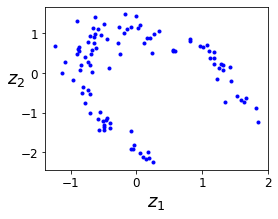

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked autoencoders 

Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. 

In this case they are called stacked autoencoders (or deep autoencoders).


The architecture of a stacked autoencoder is typically symmetrical with regards to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich.

Example (MNIST data, 28x28=784 pixel input)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/stacked.jpeg" alt="Drawing" style="width: 500px;"/>


Let's use the MNIST data as an example

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

The code should look very familiar, except that there are no labels (no y)!

In [9]:
reset_state()

n_inputs = 28 * 28 #input dimension 
n_hidden1 = 300  #first coding
n_hidden2 = 150  #second coding
n_hidden3 = n_hidden1 #symmetric decoding 
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001 #limit used in L2 reg

#Returns an initializer that generates tensors without scaling variance.
#When initializing a deep network, it is in principle advantageous to keep 
#the scale of the input variance constant, so it does not explode or 
#diminish by reaching the final layer. 
he_init = tf.keras.initializers.HeNormal() # He initialization

#Returns a function that can be used to apply L2 regularization to weights.
#Small values of L2 can help prevent overfitting the training data.
l2_regularizer = tf.keras.regularizers.L2(l2_reg)

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer),
    keras.layers.Dense(30, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer, input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

In [11]:
history = stacked_ae.fit(X_train, X_train, batch_size = 150, epochs=5,
                         validation_data=(X_valid, X_valid))

Epoch 1/5
367/367 [==============================] - 3s 6ms/step - loss: 0.4351 - rounded_accuracy: 0.8381 - val_loss: 0.3819 - val_rounded_accuracy: 0.8909
Epoch 2/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3655 - rounded_accuracy: 0.8959 - val_loss: 0.3578 - val_rounded_accuracy: 0.8986
Epoch 3/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3506 - rounded_accuracy: 0.9045 - val_loss: 0.3464 - val_rounded_accuracy: 0.9106
Epoch 4/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3416 - rounded_accuracy: 0.9086 - val_loss: 0.3392 - val_rounded_accuracy: 0.9132
Epoch 5/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3352 - rounded_accuracy: 0.9112 - val_loss: 0.3333 - val_rounded_accuracy: 0.9113


In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

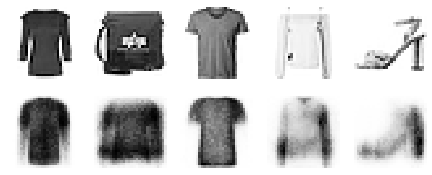

In [13]:
#showing output layer
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Can tie decoding weights to be the same as the encoder - difficult to do with dense, but can be coded manually

In [14]:
reset_state()

learning_rate = 0.01
l2_reg = 0.0005

In [15]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_regularizer=l2_regularizer)
dense_2 = keras.layers.Dense(30, activation=tf.keras.layers.ELU(), kernel_regularizer=l2_regularizer)

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation=tf.keras.layers.ELU()),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=[rounded_accuracy])

In [17]:
history = tied_ae.fit(X_train, X_train, epochs=5, batch_size=150,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
367/367 [==============================] - 3s 7ms/step - loss: 0.3435 - rounded_accuracy: 0.8979 - val_loss: 0.3194 - val_rounded_accuracy: 0.9200
Epoch 2/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3149 - rounded_accuracy: 0.9214 - val_loss: 0.3163 - val_rounded_accuracy: 0.9236
Epoch 3/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3123 - rounded_accuracy: 0.9242 - val_loss: 0.3126 - val_rounded_accuracy: 0.9267
Epoch 4/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3106 - rounded_accuracy: 0.9258 - val_loss: 0.3117 - val_rounded_accuracy: 0.9270
Epoch 5/5
367/367 [==============================] - 2s 6ms/step - loss: 0.3095 - rounded_accuracy: 0.9268 - val_loss: 0.3110 - val_rounded_accuracy: 0.9281


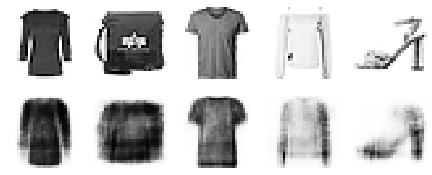

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Training One Autoencoder at a Time 

* Rather than training the whole stacked autoencoder in one go like we just did, 
* It is often much faster to train one shallow autoencoder at a time, 
* then stack all of them into a single stacked autoencoder (hence the name)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/stacked2.jpeg" alt="Drawing" style="width: 500px;"/>




Using example from tied weights above 

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

In [21]:
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

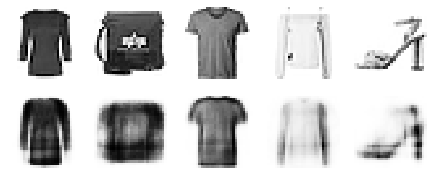

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])

In [25]:
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9350
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

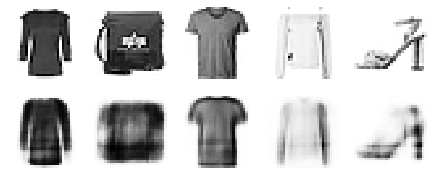

In [26]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Visualising the features

* Many ways to do this
* the simplest technique is to consider each neuron in every hidden layer, and find the training instances that activate it the most. Ok for layers close to input, but not for deep layers
* Alternatively e.g. for each neuron in the first hidden layer, you can create an image where a pixel’s intensity corresponds to the weight of the connection to the given neuron


In [27]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [28]:
for w in stacked_ae.trainable_weights:
    print(K.eval(w).shape)

(784, 100)
(100,)
(100, 30)
(30,)
(30, 100)
(100,)
(100, 784)
(784,)


In [29]:
w = stacked_ae.trainable_weights
w0 = w[0] # Weights from first layer
w0.shape

TensorShape([784, 100])

In [30]:
w0 = tf.reshape(w0, [100, 784])
w0

<tf.Tensor: shape=(100, 784), dtype=float32, numpy=
array([[ 0.01084188, -0.0279023 ,  0.01056698, ...,  0.00880016,
         0.05011347, -0.01846465],
       [-0.04671492, -0.0408097 , -0.02033382, ..., -0.00910508,
        -0.02275834,  0.02304192],
       [-0.02738582,  0.02133058,  0.00668341, ..., -0.04294644,
         0.01718999, -0.01910568],
       ...,
       [-0.04458158, -0.03678166, -0.00249851, ..., -0.02093113,
         0.02336911, -0.00249197],
       [-0.04171918,  0.02439169,  0.01663151, ...,  0.03935052,
         0.02817817,  0.00488711],
       [ 0.01971634, -0.03207907, -0.03327734, ..., -0.02435274,
        -0.0145049 , -0.00577173]], dtype=float32)>

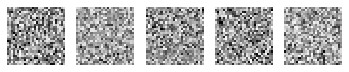

In [31]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(w0[i].numpy())

plt.show()

In [32]:
w = stacked_ae.trainable_weights
w6 = w[6] # Weights from first layer
w6.shape

TensorShape([100, 784])

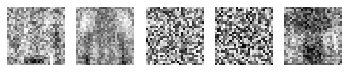

In [33]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(w6[i].numpy())

plt.show()     

## Denoising Autoencoder

* Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. 
* This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

* The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/noise.jpeg" alt="Drawing" style="width: 500px;"/>

### Gaussian Noise

Simple example (not phased training or weight matching so can use tf.keras.layers.Dense)

In [34]:
reset_state()

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

In [35]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

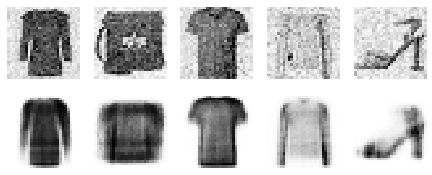

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.1)

show_reconstructions(denoising_ae, noise(X_valid, training=True).numpy())
plt.show()

### Dropout 

Simple example (not phased training or weight matching so can user tf.layers.dense)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])

In [38]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9172
Epoch 7/10
1719/1719 [==================

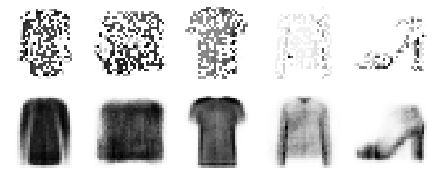

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True).numpy())
save_fig("dropout_denoising_plot", tight_layout=False)

## Variational Autoencoders 

* They are probabilistic autoencoders, meaning that their outputs are partly determined by chance,
* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.


* The encoder produces a mean coding μ and a standard deviation σ. 
* The actual coding is then sampled randomly from a Gaussian distribution with mean μ and standard deviation σ.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/var_ae.jpeg" alt="Drawing" style="width: 500px;"/>


Gaussian distribution: during training, the cost function (discussed next) pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper) spherical region that looks like a cloud of Gaussian points.


### Cost Function 

Composed of two parts: 
* The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (e.g. we can use cross entropy for this) 
* The second is the _latent loss_ that pushes the autoencoder to have codings that _look as though they were sampled from a simple Gaussian distribution_, for which we use the KL (Kullback–Leibler) divergence between the target distribution (the Gaussian distribution) and the actual distribution of the internal codings


In [40]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [42]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3895 - rounded_accuracy: 0.8610 - val_loss: 0.3537 - val_rounded_accuracy: 0.8853
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3423 - rounded_accuracy: 0.8980 - val_loss: 0.3397 - val_rounded_accuracy: 0.9047
Epoch 3/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3326 - rounded_accuracy: 0.9053 - val_loss: 0.3381 - val_rounded_accuracy: 0.9036
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3279 - rounded_accuracy: 0.9092 - val_loss: 0.3276 - val_rounded_accuracy: 0.9113
Epoch 5/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3248 - rounded_accuracy: 0.9119 - val_loss: 0.3291 - val_rounded_accuracy: 0.9125
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3227 - rounded_accuracy: 0.9134 - val_loss: 0.3238 - val_rounded_accuracy: 0.9118
Epoch 7/25
430/430 [==============================] 

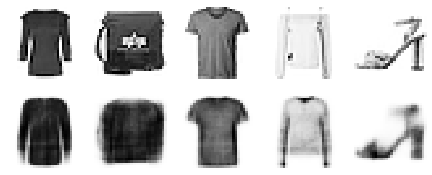

In [43]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [44]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

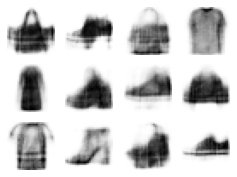

In [45]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

## No Exercise! 

* Instead go through these slides and understand the functionality 
* Also read and look at examples e.g. here https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/
    